# <div style="background-color: lightblue; padding: 10px;">Jorge et al. Conditions analysis</div>


In this notebook, we delve into the results of the Jorge et al. experiments, focusing on paraphrases across various conditions:

1. Baseline
2. Baseline-cw
3. Baseline-Outliers
4. Patterns by Example
5. Taboo Patterns

For each of these paraphrase datasets gathered through crowdsourcing, we meticulously examine the following metrics:

1. BERTscores Mean, Median, and Standard Deviation: These values provide insights into semantic relatedness among paraphrases.
2. TED Mean, Median, and Standard Deviation: This metric assesses syntactic diversity by comparing the syntax trees of specific patterns with those of the generated paraphrases.
3. Additional Statistics: We calculate various statistics, including the number of unique words, correct paraphrases, unique syntax patterns, duplicated paraphrases, and duplicated syntax patterns.

By analyzing these metrics across different dataset conditions, we aim to gain a comprehensive understanding of the quality and diversity of paraphrases produced by the respective methods.

In [1]:
import os
import pathlib
import json

# let's just make sure we are at the root
os.chdir(pathlib.Path().absolute().parent)
current_directory = os.getcwd()
new_directory = f"{current_directory}/Jorge_paper_replication"
os.chdir(new_directory)
print(f"Current working directory: {os.getcwd()}")

Current working directory: /home/jovyan/test/Jorge_paper_replication


In [3]:
import random
import requests
from collections import Counter
from itertools import cycle
import time
import math
import warnings
import pandas as pd
import numpy as np
import stanza
import seaborn as sns
from tqdm import tqdm
from transformers import logging
from bert_score import score
import matplotlib.pyplot as plt
from termcolor import colored

from lib import metrics
from lib import utility as utlty
from lib import prompts_utility
from lib import gpt_utility

logging.set_verbosity_error()#suppressing the display of warning messages.
warnings.simplefilter(action='ignore', category=FutureWarning)#suppress Pandas Future warning

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Import stanza model
import stanza
nlp = stanza.Pipeline(lang='en', processors='tokenize,pos,constituency', tokenize_no_ssplit=True)

2023-08-28 08:40:46 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2023-08-28 08:40:52 INFO: Loading these models for language: en (English):
| Processor    | Package  |
---------------------------
| tokenize     | combined |
| pos          | combined |
| constituency | wsj      |

2023-08-28 08:40:52 INFO: Using device: cuda
2023-08-28 08:40:52 INFO: Loading: tokenize
2023-08-28 08:40:55 INFO: Loading: pos
2023-08-28 08:40:56 INFO: Loading: constituency
2023-08-28 08:40:57 INFO: Done loading processors!


In [21]:
CONDITIONS = ["baseline", "baseline-cw", "baseline-outliers", "patterns-examples", "taboo-patterns"]

input_file = f"{os.getcwd()}/input/Jorge-main-all-with-bertscores.csv"#test_data
df = pd.read_csv(input_file)

print(f"df.shape: {df.shape}")
print(len(df.columns))
print(df.columns)
df.head(3)

df.shape: (6120, 58)
58
Index(['coding_1', 'select', 'rand', 'select_overlap', 'coding_2',
       'Calibration', 'INPUT:row_pk', 'INPUT:intent',
       'input utterance [coding]', 'INPUT:input_utterance_bootstrap',
       'INPUT:input_utterance', 'INPUT:parameters', 'paraphrase_value',
       'is_correct', 'tag', 'paraphrase_key', 'INPUT:source', 'INPUT:pool_id',
       'INPUT:input_pattern', 'paraphrase_pattern', 'INPUT:rand_cw',
       'INPUT:is_correct', 'INPUT:masked_ngrams', 'INPUT:rand_baseline',
       'INPUT:prompt_context', 'INPUT:target_patterns',
       'INPUT:distance_to_mean', 'INPUT:distance_to_seed',
       'INPUT:input_utterance_words', 'INPUT:input_utterance_lemmatized_words',
       'OUTPUT:trace', 'OUTPUT:worker_uuid', 'OUTPUT:screen_width',
       'OUTPUT:screen_height', 'OUTPUT:page_started_at',
       'OUTPUT:provided_ngrams', 'OUTPUT:page_started_at_string',
       'ASSIGNMENT:link', 'ASSIGNMENT:task_id', 'ASSIGNMENT:assignment_id',
       'ASSIGNMENT:task_suite_

,coding_1,select,rand,select_overlap,coding_2,Calibration,INPUT:row_pk,INPUT:intent,input utterance [coding],INPUT:input_utterance_bootstrap,...,ASSIGNMENT:expired,ASSIGNMENT:reward,judgment_time_3p,judgment_time_1p,Jorge,Jorge-tag,Marcos,Marcos-tag,J-M Agreement,bert_score
0,Jorge,False,0.623851,False,NaN,False,1,EndEC2Instance,"""Terminate i-a541 now""","""Terminate i-a541 now""",...,NaN,0.15,97.699,32.566333,1.0,NaN,NaN,NaN,NaN,0.436592
1,Jorge,False,0.662712,False,NaN,False,1,EndEC2Instance,"""Terminate i-a541 now""","""Terminate i-a541 now""",...,NaN,0.15,97.699,32.566333,1.0,NaN,NaN,NaN,NaN,0.526650
2,Jorge,False,0.118898,False,NaN,False,1,EndEC2Instance,"""Terminate i-a541 now""","""Terminate i-a541 now""",...,NaN,0.15,97.699,32.566333,0.0,NaN,NaN,NaN,NaN,0.485834


In [22]:
input_file = f"{os.getcwd()}/input/Jorge-bootstrap-with-bertscores.csv"#test_data
df_bootstrap = pd.read_csv(input_file)
# we computed the bert_scores on colab

df_bootstrap.shape

(1224, 44)

# <div style="background-color: #ca8fb4; padding: 10px;">Add syntax tree templates</div>

In [25]:
def apply_extract_syntax_pattern(df, nlp, selected_column_name, syntax_columns_name):
    """
    Apply the utlty.extract_syntax_pattern function to a row of the DataFrame.

    :args
        de (pandas.dataframe): A DataFrame.
        nlp (stanza.pipeline): The stanza piepline to extract consittuency parse tree.
        selected_column_name (str): Name of the column to process.
        syntax_columns_name (str): the name of the syntax column

    :returns
        None
    """
    p_templates = []
    
    for index, row in tqdm(df.iterrows(),position=0, leave=True):
        selected_row = row[selected_column_name]
        # some utterance are between quotes remove it e.g. "Terminate i-a541 now" -> <Terminate i-a541 now
        selected_row = selected_row.strip('"') if selected_row.startswith('"') and selected_row.endswith('"') else selected_row
        paraphrase_syntax_template, _, _ = utlty.extract_syntax_pattern(nlp, selected_row)
        p_templates.append(paraphrase_syntax_template)
    
    df[syntax_columns_name] = p_templates

### <div style="background-color: #f7b1a9; padding: 10px; display: inline-block;">Add syntax tree templates for df dataframe</div>

In [26]:
# add ted for INPUT:input_utterance'
selected_column = 'INPUT:input_utterance'  
syntax_column_name = 'input_pattern'

apply_extract_syntax_pattern(df, nlp, selected_column, syntax_column_name)

df.head(3)[['INPUT:input_utterance','input_pattern']]

6120it [05:43, 17.81it/s]


,INPUT:input_utterance,input_pattern
0,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )
1,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )
2,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) )


In [27]:
# add ted for INPUT:input_utterance'
selected_column = 'paraphrase_value'  
syntax_column_name = 'paraphrase_pattern'

apply_extract_syntax_pattern(df, nlp, selected_column, syntax_column_name)

df.head(3)[['paraphrase_value', 'paraphrase_pattern']]

6120it [06:10, 16.54it/s]


,paraphrase_value,paraphrase_pattern
0,Get over with i-a541,( S ( VP ( VB ) ( ADVP ) ( PP ) ) )
1,Get i-a541 done,( S ( VP ( VB ) ( NP ) ( VBN ) ) )
2,Do I-a541,"( SQ ( VBP ) ( NP ( PRP ) ) ( , ) ( NP ( CD ) ) )"


In [28]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/df_all_with_syntax_pattern.csv"
df.to_csv(path_to_plot_file, index=False)

## <div style="background-color: #ecb9c9; padding: 10px; display: inline-block;">Add syntax tree templates for df_bootstrap dataframe</div>

In [29]:
# add ted for INPUT:input_utterance'
selected_column = 'INPUT:input_utterance'  
syntax_column_name = 'input_pattern'

apply_extract_syntax_pattern(df_bootstrap, nlp, selected_column, syntax_column_name)

df_bootstrap.head(3)[['INPUT:input_utterance','input_pattern']]

1224it [01:09, 17.67it/s]


,INPUT:input_utterance,input_pattern
0,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
1,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) )
2,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) )


In [30]:
# add ted for INPUT:input_utterance'
selected_column = 'paraphrase_value'  
syntax_column_name = 'paraphrase_pattern'

apply_extract_syntax_pattern(df_bootstrap, nlp, selected_column, syntax_column_name)

df_bootstrap.head(3)[['paraphrase_value', 'paraphrase_pattern']]

1224it [01:09, 17.60it/s]


,paraphrase_value,paraphrase_pattern
0,Finish i-a541 now.,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) )
1,Complete i-a541 now.,( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...
2,End i-a541 now.,( S ( VP ( NN ) ( NP ) ( ADVP ) ) ( . ) )


In [31]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/bootstrap_df_with_syntax_pattern.csv"
df_bootstrap.to_csv(path_to_plot_file, index=False)
df_bootstrap.shape

(1224, 45)

## <div style="background-color: #c6c2b6; padding: 10px;">Add TED scores</div>

In [32]:
def compute_ted_for_paraphrases(df,column1,column2):
    """
    Compute the Tree Edit Distance (TED) for each paraphrase in the DataFrame.

    :args
        df (pd.DataFrame): The DataFrame containing the paraphrases and their syntax templates.
        column1 (str): first column pair
        column2 (str): second column pair
    
    :return
        None
    """

    ted_scores = []
    
    for index, row in tqdm(df.iterrows(),position=0, leave=True):
        ted_score = utlty.syn_utility.compute_tree_edit_distance(row[column1], row[column2])
        ted_scores.append(ted_score)
    
    df["ted"] = ted_scores


In [33]:
# add TED to df
syntax_column_1 = 'input_pattern'
syntax_column_2 = 'paraphrase_pattern'
compute_ted_for_paraphrases(df, syntax_column_1,syntax_column_2)

df.head(3)[['INPUT:input_utterance','input_pattern','ted']]

6120it [00:04, 1281.24it/s]


,INPUT:input_utterance,input_pattern,ted
0,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),6.0
1,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),6.0
2,"""Finish i-a541 now""",( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),7.0


In [34]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/df_all_with_ted_scores.csv"
df.to_csv(path_to_plot_file, index=False)

In [35]:
# add TED to df_bootstrap
syntax_column_1 = 'input_pattern'
syntax_column_2 = 'paraphrase_pattern'
compute_ted_for_paraphrases(df_bootstrap, syntax_column_1,syntax_column_2)

df_bootstrap.head(3)[['INPUT:input_utterance','input_pattern','ted']]

1224it [00:01, 804.11it/s]


,INPUT:input_utterance,input_pattern,ted
0,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),1.0
1,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),6.0
2,"""Terminate i-a541 now""",( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),2.0


In [36]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/bootstrap_df_with_ted_scores.csv"
df_bootstrap.to_csv(path_to_plot_file, index=False)
df_bootstrap.shape

(1224, 46)

# <div style="background-color: #FF7276; padding: 10px; display: inline-block;">Sanity Check</div>
As part of our sanity check procedure, we initiate a comprehensive review process. This entails the elimination of duplicate and semantically unrelated paraphrases. Our approach leverages the manual evaluation done by Jorge et al. namely the is_correct column. We only selected the columns with True value.

In [37]:
df.shape

(6120, 60)

In [38]:
correct_df = df[(df['bert_score'] >= 0.5) & (df['bert_score'] <= 0.98)].copy()
correct_df.shape

(3521, 60)

In [41]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/df_all_only_correct_paraphrases.csv"
correct_df.to_csv(path_to_plot_file, index=False)

In [39]:
df_bootstrap.shape

(1224, 46)

In [42]:
correct_bootstrap =  df_bootstrap[(df_bootstrap['bert_score'] >= 0.5) & (df_bootstrap['bert_score'] <= 0.98)].copy()
correct_bootstrap.shape

(790, 46)

In [43]:
path_to_plot_file = f"{os.getcwd()}/output/Jorge/bootstrap_df_only_correct_paraphrases.csv"
correct_bootstrap.to_csv(path_to_plot_file, index=False)

# Syntactic novelty

We generate a table with the number of unique pattern (per seed) not found in the bootstrap round. 

In [22]:
# seed, bootstrap, cnd1, cnd1_novel, cond2,  cond2_novel
#  1    5          10,          5     3,     0

def get_novel_df(df_main, df_boot):
  entries = []
  bootstrap_patterns = {} # row_pk => Set()

  for row_pk in df_boot["INPUT:row_pk"].unique():
    df_row = df_boot[df_boot["INPUT:row_pk"] == row_pk]
    entries.append({
      "row_pk": row_pk,
      "bootstrap": df_row["paraphrase_pattern"].nunique()
    })
    bootstrap_patterns[row_pk] = set(df_row["paraphrase_pattern"].unique())

  # add columns for main
  for entry in entries:
    row_pk = entry["row_pk"]
    
    for cnd in CONDITIONS:
      df_row_cnd = df_main[(df_main["INPUT:row_pk"] == row_pk) & (df_main["INPUT:pool_id"] == cnd)]
      entry[cnd] = df_row_cnd["paraphrase_pattern"].nunique()
      row_cnd_patterns = set(df_row_cnd["paraphrase_pattern"].unique())
      entry[f"{cnd}-novel"] = len(row_cnd_patterns - bootstrap_patterns[row_pk])

  df_novelty = pd.DataFrame(entries, columns=["row_pk", "bootstrap"] + CONDITIONS + [f"{cnd}-novel" for cnd in CONDITIONS])
  return df_novelty

In [23]:
print(f"Syntactic novelty for is_correct == True:")
df_novelty = get_novel_df(df[df.is_correct == 1], df_bootstrap[df_bootstrap.is_correct == 1])
df_novelty.head()

Syntactic novelty for is_correct == True:


,row_pk,bootstrap,baseline,baseline-cw,baseline-outliers,patterns-examples,taboo-patterns,baseline-novel,baseline-cw-novel,baseline-outliers-novel,patterns-examples-novel,taboo-patterns-novel
0,3,10,6,4,7,11,9,3,1,6,10,9
1,4,14,8,15,13,12,17,7,11,10,8,17
2,5,16,14,15,10,17,16,13,14,10,17,16
3,6,7,4,9,13,9,11,4,9,13,8,11
4,7,7,14,9,11,8,11,12,9,9,7,10


In [25]:
print(f"Syntactic novelty for correct paraphrases only:")
df_novelty_correct = get_novel_df(correct_df, correct_bootstrap)
df_novelty_correct

Syntactic novelty for correct paraphrases only:


,row_pk,bootstrap,baseline,baseline-cw,baseline-outliers,patterns-examples,taboo-patterns,baseline-novel,baseline-cw-novel,baseline-outliers-novel,patterns-examples-novel,taboo-patterns-novel
0,3,10,6,4,7,11,9,3,1,6,10,9
1,4,14,8,15,13,12,17,7,11,10,8,17
2,5,16,14,15,10,17,16,13,14,10,17,16
3,6,7,4,9,13,9,11,4,9,13,8,11
4,7,7,14,9,11,8,11,12,9,9,7,10
5,8,15,14,17,7,15,18,12,15,7,11,17
6,9,9,8,3,9,7,4,7,3,9,7,4
7,10,12,17,13,13,12,18,14,11,9,11,16
8,11,7,8,7,3,2,0,4,5,3,2,0
9,12,3,1,3,1,1,0,1,1,1,1,0


In [26]:
#save the syntax novelty count
output_file = f"{os.getcwd()}/output/Jorge/correct_df_paraphrases_syntax_novelty_stats.csv"
df_novelty_correct.to_csv(output_file, index=False)

### <div style="background-color: lightgreen; padding: 10px; display: inline-block;">Mean Number of Unique Syntax Patterns</div>

In [12]:
mean_values = df_novelty_correct.mean()
median_values = df_novelty_correct.median()

In [14]:
mean_values

row_pk                     26.520833
bootstrap                  11.270833
baseline                   10.083333
baseline-cw                11.666667
baseline-outliers           9.000000
patterns-examples          12.687500
taboo-patterns             11.895833
baseline-novel              8.125000
baseline-cw-novel           9.083333
baseline-outliers-novel     7.625000
patterns-examples-novel    11.395833
taboo-patterns-novel       11.062500
dtype: float64

In [13]:
median_values

row_pk                     26.5
bootstrap                  11.5
baseline                    9.5
baseline-cw                12.5
baseline-outliers           9.0
patterns-examples          14.0
taboo-patterns             12.0
baseline-novel              8.0
baseline-cw-novel           9.0
baseline-outliers-novel     7.5
patterns-examples-novel    12.0
taboo-patterns-novel       11.0
dtype: float64

### Syntactic novelty stats

In [27]:
mean_values = df_novelty_correct.mean()

median_values = df_novelty_correct.median()

std_values = df_novelty_correct.std()

total_values = df_novelty_correct.sum()

# Combine the results into a new DataFrame for better visualization
summary_df = pd.DataFrame({
    'Mean': mean_values,
    'Median': median_values,
    'Standard Deviation': std_values,
    'Total': total_values
})
summary_df

,Mean,Median,Standard Deviation,Total
row_pk,26.520833,26.5,14.036411,1273
bootstrap,11.270833,11.5,4.992503,541
baseline,10.083333,9.5,5.081604,484
baseline-cw,11.666667,12.5,5.191373,560
baseline-outliers,9.000000,9.0,5.649327,432
patterns-examples,12.687500,14.0,5.604543,609
taboo-patterns,11.895833,12.0,6.301771,571
baseline-novel,8.125000,8.0,4.427309,390
baseline-cw-novel,9.083333,9.0,4.360526,436
baseline-outliers-novel,7.625000,7.5,5.249620,366


## Median novelty per condition

In [47]:
# Median "novelty"
df_novelty[["baseline-novel", "baseline-cw-novel", "baseline-outliers-novel", "patterns-examples-novel", "taboo-patterns-novel"]].median()

baseline-novel              9.0
baseline-cw-novel           9.0
baseline-outliers-novel     8.0
patterns-examples-novel    12.0
taboo-patterns-novel       10.0
dtype: float64

In [48]:
# Median "novelty"
df_novelty_correct[["baseline-novel", "baseline-cw-novel", "baseline-outliers-novel", "patterns-examples-novel", "taboo-patterns-novel"]].median()

baseline-novel              8.0
baseline-cw-novel           9.0
baseline-outliers-novel     7.5
patterns-examples-novel    12.0
taboo-patterns-novel       11.0
dtype: float64

## Median unique patterns per condition

In [49]:
# Median unique
df_novelty[["bootstrap"] + CONDITIONS].median()

bootstrap            12.0
baseline             11.0
baseline-cw          12.0
baseline-outliers    11.0
patterns-examples    14.0
taboo-patterns       11.0
dtype: float64

In [50]:
df_novelty_correct[["bootstrap"] + CONDITIONS].median()

bootstrap            11.5
baseline              9.5
baseline-cw          12.5
baseline-outliers     9.0
patterns-examples    14.0
taboo-patterns       12.0
dtype: float64

# Pattern distribution
We generate the number of paraphrases per unique pattern (per seed and condition).

In [51]:
# Seed, N, Pattern, Condition, Count
# bootstrap + second_round
# count: paraphrases


def get_pattern_distribution_df_v1(df_main):
  entries = []
  for row_pk in df_main["INPUT:row_pk"].unique():
    for cnd in CONDITIONS:
      df_rows_cnd = df_main[(df_main["INPUT:row_pk"] == row_pk) & (df_main["INPUT:pool_id"] == cnd)]
      row_patterns = df_rows_cnd["paraphrase_pattern"].unique()

      for rp in row_patterns:
        entries.append({
          "row_pk": row_pk,
          "total_paraphrases": df_rows_cnd.shape[0],
          "pattern": rp,
          "condition": cnd,
          "count": df_rows_cnd[df_rows_cnd["paraphrase_pattern"] == rp].shape[0]
        })
  df_dist = pd.DataFrame(entries)
  return df_dist



def get_pattern_distribution_df(df_main, df_boot):
  entries = []
  for row_pk in df_main["INPUT:row_pk"].unique():
    for cnd in CONDITIONS:
      df_rows_cnd = df_main[(df_main["INPUT:row_pk"] == row_pk) & (df_main["INPUT:pool_id"] == cnd)]
      df_rows_cnd_boot = df_boot[df_boot["INPUT:row_pk"] == row_pk]
      row_patterns = set(list(df_rows_cnd["paraphrase_pattern"].unique())+  list(df_rows_cnd_boot["paraphrase_pattern"].unique()))

      for rp in row_patterns:
        entries.append({
          "row_pk": row_pk,
          "total_paraphrases": df_rows_cnd.shape[0] + df_rows_cnd_boot.shape[0],
          "pattern": rp,
          "in_bootstrap": df_rows_cnd_boot[df_rows_cnd_boot["paraphrase_pattern"] == rp].shape[0] > 0,
          "count_in_bootstrap": df_rows_cnd_boot[df_rows_cnd_boot["paraphrase_pattern"] == rp].shape[0],
          "condition": cnd,
          "count": df_rows_cnd[df_rows_cnd["paraphrase_pattern"] == rp].shape[0] + df_rows_cnd_boot[df_rows_cnd_boot["paraphrase_pattern"] == rp].shape[0],
        })
  df_dist = pd.DataFrame(entries)
  return df_dist

In [52]:
df_dist = get_pattern_distribution_df(df[df.is_correct == 1], df_bootstrap[df_bootstrap.is_correct == 1])

## <div style="background-color: lightblue; padding: 10px;">For correct only</div>

In [53]:
df_dist.sort_values(by=["row_pk", "condition", "count_in_bootstrap"], ascending=[True, True, False], inplace=True)
df_dist.head(5)

,row_pk,total_paraphrases,pattern,in_bootstrap,count_in_bootstrap,condition,count
15,1,39,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),True,7,baseline,13
10,1,39,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),True,4,baseline,4
14,1,39,( S ( NP ( PRP ) ) ( VP ( VBP ) ( VP ) ) ( . ) ),True,2,baseline,2
17,1,39,( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),True,2,baseline,2
1,1,39,( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...,True,1,baseline,1


In [54]:
df_dist_correct = get_pattern_distribution_df(correct_df, correct_bootstrap)

In [55]:
df_dist_correct.sort_values(by=["row_pk", "condition", "count_in_bootstrap"], ascending=[True, True, False], inplace=True)
df_dist_correct.head(5)

,row_pk,total_paraphrases,pattern,in_bootstrap,count_in_bootstrap,condition,count
0,1,8,( S ( NP ( PRP ) ) ( VP ( VBP ) ( PP ) ( ADVP ...,False,0,baseline,1
1,1,8,( SQ ( MD ) ( NP ( PRP ) ) ( VP ( VB ) ( NP ) ...,False,0,baseline,1
2,1,8,( S ( VP ( VB ) ( PRT ) ( NP ) ) ),False,0,baseline,1
3,1,8,( S ( NP ( VB ) ( NN ) ) ( ADVP ( RB ) ) ),False,0,baseline,1
4,1,8,( S ( NP ( PRP ) ) ( VP ( VBP ) ( S ) ) ),False,0,baseline,1


In [56]:
df_dist.sort_values(by=["row_pk", "condition", "count_in_bootstrap"], ascending=[True, True, False], inplace=True)
df_dist.head(5)

,row_pk,total_paraphrases,pattern,in_bootstrap,count_in_bootstrap,condition,count
15,1,39,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ),True,7,baseline,13
10,1,39,( S ( VP ( VB ) ( NP ) ( ADVP ) ) ( . ) ),True,4,baseline,4
14,1,39,( S ( NP ( PRP ) ) ( VP ( VBP ) ( VP ) ) ( . ) ),True,2,baseline,2
17,1,39,( S ( NP ( NN ) ( NN ) ) ( ADVP ( RB ) ) ),True,2,baseline,2
1,1,39,( FRAG ( NP ( JJ ) ( NN ) ) ( ADVP ( RB ) ) ( ...,True,1,baseline,1


In [57]:
def get_std_df(df_dist):
  entries = []
  for row_pk in df_dist["row_pk"].unique():
    for cnd in CONDITIONS:
      df_rows_cnd = df_dist[(df_dist["row_pk"] == row_pk) & (df_dist["condition"] == cnd)]
      entries.append({
        "row_pk": row_pk,
        "condition": cnd,
        "std": df_rows_cnd["count"].std()
      })
  return pd.DataFrame(entries)

In [58]:
df_std = get_std_df(df_dist)
df_std.head()

,row_pk,condition,std
0,1,baseline,2.758294
1,1,baseline-cw,3.368321
2,1,baseline-outliers,2.708013
3,1,patterns-examples,2.480980
4,1,taboo-patterns,1.559798


In [59]:
df_std_correct = get_std_df(df_dist_correct)
df_std_correct.head()

,row_pk,condition,std
0,1,baseline,0.000000
1,1,baseline-cw,2.041241
2,1,baseline-outliers,1.133893
3,1,patterns-examples,1.293340
4,1,taboo-patterns,0.000000


In [60]:
df_std.to_csv(f"{os.getcwd()}/output/Jorge/main-pattern-std.csv", index=False)

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


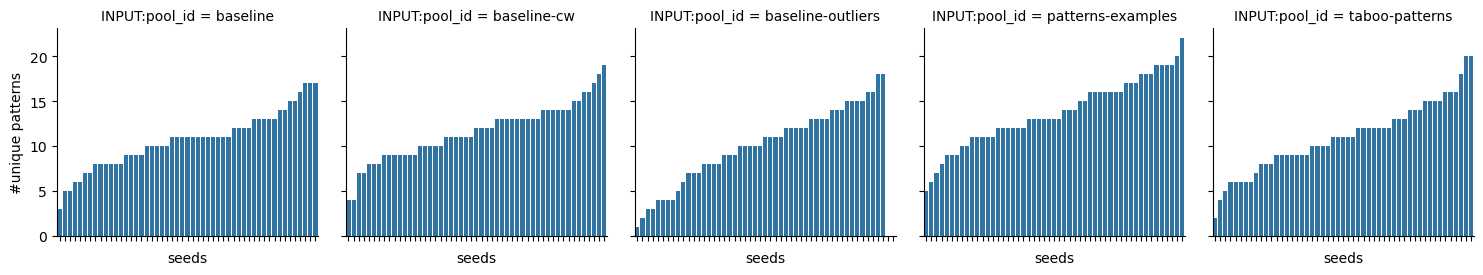

In [248]:
## Unique patterns per seed
#In the following chart, each blue bar is a seed and its height represents the number of unique patterns for the seed.

df["INPUT:row_pk"] = df["INPUT:row_pk"].apply(lambda x: str(x))
df_p = df.drop_duplicates(subset=["INPUT:row_pk", "INPUT:pool_id", "paraphrase_pattern"])
df_p = df_p[df_p.is_correct == 1]
df_p = df_p.groupby(by=["INPUT:row_pk", "INPUT:pool_id"])['paraphrase_pattern'].count().reset_index(name='Count').sort_values(['Count'], ascending=True)
g = sns.FacetGrid(df_p, col="INPUT:pool_id", col_order=["baseline", "baseline-cw", "baseline-outliers", "patterns-examples", "taboo-patterns"])
g.map(sns.barplot, "INPUT:row_pk", "Count")
g.set(xlabel="seeds")
g.set(xticklabels=[])
g.set(ylabel="#unique patterns")

## Just select correct paraphrases

In [12]:
df_taboo = correct_df[correct_df["INPUT:pool_id"] == "taboo-patterns"].copy()
df_baseline = correct_df[correct_df["INPUT:pool_id"] == "baseline"].copy()
df_baseline_cw = correct_df[correct_df["INPUT:pool_id"] == "baseline-cw"].copy()
df_out = correct_df[correct_df["INPUT:pool_id"] == "baseline-outliers"].copy()
df_patterns = correct_df[correct_df["INPUT:pool_id"] == "patterns-examples"].copy()

# correct_df, correct_bootstrap

In [13]:
df_list = [
    correct_bootstrap.copy(),
    df_baseline,
    df_baseline_cw,
    df_out,
    df_taboo,
    df_patterns
]

df_names = ["bootstrap","baseline", "baseline_cw", "baseline_otlier", "taboo_patterns", "patterns_by_example"]

In [8]:
for d,n in zip(df_list,df_names):
    print(f"{n}: {d.shape}")

bootstrap: (790, 46)
baseline: (744, 60)
baseline_cw: (742, 60)
baseline_otlier: (651, 60)
taboo_patterns: (658, 60)
patterns_by_example: (726, 60)


In [15]:
for names, tmp_df in zip(df_names,df_list):
    p_candidates = tmp_df.paraphrase_value.to_list()
    p_candidates = [x.lower() for x in p_candidates]#lowercase all paraphrases
    unique_p_candidates = set(p_candidates)
    num_duplicates = len(p_candidates) - len(unique_p_candidates)
    
    print(
        f"Count of recurring paraphrases, in {names}"\
        f" among the paraphrase set. For a list of {len(p_candidates)} correct paraphrases collected {num_duplicates} are duplicates."
        ""
    )

Count of recurring paraphrases, in bootstrap among the paraphrase set. For a list of 790 correct paraphrases collected 34 are duplicates.
Count of recurring paraphrases, in baseline among the paraphrase set. For a list of 744 correct paraphrases collected 33 are duplicates.
Count of recurring paraphrases, in baseline_cw among the paraphrase set. For a list of 742 correct paraphrases collected 7 are duplicates.
Count of recurring paraphrases, in baseline_otlier among the paraphrase set. For a list of 651 correct paraphrases collected 14 are duplicates.
Count of recurring paraphrases, in taboo_patterns among the paraphrase set. For a list of 658 correct paraphrases collected 8 are duplicates.
Count of recurring paraphrases, in patterns_by_example among the paraphrase set. For a list of 726 correct paraphrases collected 3 are duplicates.


In [82]:
list_duplicates_df = []

for names, tmp_df in zip(df_names,df_list):
    duplicates_data = []
    p_candidates_length = 0
    
    for utr in tmp_df["INPUT:input_utterance"].unique():
        df_row = tmp_df[tmp_df["INPUT:input_utterance"] == utr]
        p_candidates = df_row.paraphrase_pattern.to_list()
        p_candidates_length += len(p_candidates)
        unique_p_candidates = set(p_candidates)
        num_duplicates = len(p_candidates) - len(unique_p_candidates)
        duplicates_data.append({"input_utterance": utr, "num_duplicates": num_duplicates})
    sum_dup = sum(d["num_duplicates"] for d in duplicates_data)
    print(
        f"Count of recurring syntax, in {names}"\
        f" among the syntax templates set. For a list of {p_candidates_length} correct paraphrases collected {sum_dup} are duplicates."
        ""
    )
    duplicates_data.append({"input_utterance": "Total number of duplicates in df_taboo", "num_duplicates": sum_dup})
    duplicates_df = pd.DataFrame(duplicates_data)
    
    list_duplicates_df.append(duplicates_df)


# for d in list_duplicates_df:
#     print(d.tail(1)['num_duplicates'].values[0])

Count of recurring syntax, in bootstrap among the syntax templates set. For a list of 790 correct paraphrases collected 249 are duplicates.
Count of recurring syntax, in baseline among the syntax templates set. For a list of 744 correct paraphrases collected 248 are duplicates.
Count of recurring syntax, in baseline_cw among the syntax templates set. For a list of 742 correct paraphrases collected 91 are duplicates.
Count of recurring syntax, in baseline_otlier among the syntax templates set. For a list of 651 correct paraphrases collected 198 are duplicates.
Count of recurring syntax, in taboo_patterns among the syntax templates set. For a list of 658 correct paraphrases collected 78 are duplicates.
Count of recurring syntax, in patterns_by_example among the syntax templates set. For a list of 726 correct paraphrases collected 100 are duplicates.


In [66]:
def get_mean_median(df_list, df_names):
    for df, names in zip(df_list,df_names):
        msg = f"Mean and Median scores for {names}"
        print("-"*len(msg))
        print(msg)
        print("-"*len(msg))
        print(f"  BERT Mean: {df['bert_score'].mean()}")
        print(f"  BERT Median: {df['bert_score'].median()}")
        print(f"  BERT standard deviation: {df['bert_score'].std()}")
        
        print(f"  TED Mean: {df['ted'].mean()}")
        print(f"  TED Median: {df['ted'].median()}")
        print(f"  TED standard deviation: {df['ted'].std()}")
        print()
        print()

In [67]:
get_mean_median(df_list, df_names)

------------------------------------
Mean and Median scores for bootstrap
------------------------------------
  BERT Mean: 0.6356243452025316
  BERT Median: 0.62709697
  BERT standard deviation: 0.08107737910818448
  TED Mean: 3.669620253164557
  TED Median: 4.0
  TED standard deviation: 2.8924031623078026


-----------------------------------
Mean and Median scores for baseline
-----------------------------------
  BERT Mean: 0.6257423853225808
  BERT Median: 0.616864485
  BERT standard deviation: 0.07799086043613988
  TED Mean: 3.8225806451612905
  TED Median: 4.0
  TED standard deviation: 2.842804106624728


--------------------------------------
Mean and Median scores for baseline_cw
--------------------------------------
  BERT Mean: 0.62759892819407
  BERT Median: 0.6250349
  BERT standard deviation: 0.08024874922445854
  TED Mean: 3.6482479784366575
  TED Median: 4.0
  TED standard deviation: 2.862855496814969


------------------------------------------
Mean and Median scores 

In [68]:
def get_ted_compliance(df_list, df_names):
    for df, names in zip(df_list, df_names):
        msg = f"TED compliance scores for {names}"
        print("-" * len(msg))
        print(msg)
        print("-" * len(msg))

        ted_values = [0, 1, 2, 3]
        
        for ted_value in ted_values:
            count = df['ted'].value_counts().get(ted_value, 0)
            print(f"  TED = {ted_value} occurred {count}")
        
        print()
        print()

In [69]:
get_ted_compliance(df_list, df_names)

-----------------------------------
TED compliance scores for bootstrap
-----------------------------------
  TED = 0 occurred 129
  TED = 1 occurred 124
  TED = 2 occurred 81
  TED = 3 occurred 56


----------------------------------
TED compliance scores for baseline
----------------------------------
  TED = 0 occurred 120
  TED = 1 occurred 100
  TED = 2 occurred 67
  TED = 3 occurred 47


-------------------------------------
TED compliance scores for baseline_cw
-------------------------------------
  TED = 0 occurred 133
  TED = 1 occurred 95
  TED = 2 occurred 79
  TED = 3 occurred 56


-----------------------------------------
TED compliance scores for baseline_otlier
-----------------------------------------
  TED = 0 occurred 112
  TED = 1 occurred 79
  TED = 2 occurred 78
  TED = 3 occurred 51


----------------------------------------
TED compliance scores for taboo_patterns
----------------------------------------
  TED = 0 occurred 5
  TED = 1 occurred 17
  TED = 2 occur

### <div style="background-color:  	#bbd0c9; padding: 10px;">Count unique syntax</div>

In [70]:
for df, names in zip(df_list, df_names):
    print(f"{names}: {df.paraphrase_pattern.unique().shape}")

bootstrap: (343,)
baseline: (332,)
baseline_cw: (364,)
baseline_otlier: (297,)
taboo_patterns: (425,)
patterns_by_example: (431,)


# Conformity with patterns

Here we focus on the patterns-examples condition and we check the number of paraphrases that match the pattern found in any of the examples

In [71]:
def get_pattern(paraphrase: str):
  def __get_pattern(s: str):
    template = text.get_parse_template(s)
    template = " ".join(template)
    return template
  
  sentences = sent_tokenize(paraphrase)
  
  if len(sentences) > 1:
    template = ""
    for s in sentences:
      template += __get_pattern(s)
    return template
  # we only remove "." for single sentences as the "." introduces the "( . )" in the pattern that can introduce negligible differences.
  return __get_pattern(paraphrase).replace(" ( . )", "")

In [287]:
total = df_patterns.shape[0]
matches = 0
pattern_map = {} # utterance -> pattern

for _, row in df_patterns.iterrows():
  for target in row["INPUT:target_patterns"]:
    utterance = target[1]

    if utterance not in pattern_map:
      pattern_map[utterance] = get_pattern(utterance)
    paraphrase_pattern = row["paraphrase_pattern"]

    if paraphrase_pattern == pattern_map[utterance]:
      matches += 1
      break

pct_conformity = (matches / total) * 100.0
print(f"Percentage conformity: {pct_conformity:.2f}")

IndexError: string index out of range

# Conformity to seed in the baselines?

In [40]:
def get_pct_conformity_seed(df_base):
  total = df_base.shape[0]
  matches = 0

  for _, row in df_base.iterrows():
    if row["paraphrase_pattern"] == row["INPUT:input_pattern"]:
      matches += 1
  
  return (matches / total) * 100.0


baseline = get_pct_conformity_seed(df[(df.is_correct == 1) & (df["INPUT:pool_id"] == "baseline")])
baseline_cw = get_pct_conformity_seed(df[(df.is_correct == 1) & (df["INPUT:pool_id"] == "baseline-cw")])
baseline_outliers = get_pct_conformity_seed(df[(df.is_correct == 1) & (df["INPUT:pool_id"] == "baseline-outliers")])

print(f"baseline: {baseline}")
print(f"baseline-cw: {baseline_cw}")
print(f"baseline-outliers: {baseline_outliers}")

baseline: 16.52490886998785
baseline-cw: 16.580976863753214
baseline-outliers: 13.352685050798257


In [41]:
df[(df.is_correct == 1) & (df["INPUT:pool_id"] == "baseline")][["INPUT:input_pattern", "paraphrase_pattern"]]

,INPUT:input_pattern,paraphrase_pattern
60,( ROOT ( NP ( FRAG ) ) ),( ROOT ( FRAG ( S ) ( : ) ( NP ) ) )
62,( ROOT ( NP ( FRAG ) ) ),( ROOT ( FRAG ( S ) ( : ) ( NP ) ) )
67,( ROOT ( NP ( FRAG ) ) ),( ROOT ( SQ ( MD ) ( NP ) ( VP ) ) )
69,( ROOT ( NP ( FRAG ) ) ),( ROOT ( FRAG ( NP ) ( ADVP ) ( NP ) ( ADVP ) ) )
70,( ROOT ( NP ( FRAG ) ) ),( ROOT ( FRAG ( S ) ( : ) ( NP ) ) )
...,...,...
6105,( ROOT ( SBARQ ( `` ) ( WHNP ) ( SQ ) ( '' ) ) ),( ROOT ( SBARQ ( WHNP ) ( SQ ) ) )
6107,( ROOT ( SBARQ ( `` ) ( WHNP ) ( SQ ) ( '' ) ) ),( ROOT ( SQ ( MD ) ( NP ) ( VP ) ) )
6108,( ROOT ( SBARQ ( `` ) ( WHNP ) ( SQ ) ( '' ) ) ),( ROOT ( SBARQ ( WHNP ) ( SQ ) ) )
6110,( ROOT ( SBARQ ( `` ) ( WHNP ) ( SQ ) ( '' ) ) ),( ROOT ( SBARQ ( WHNP ) ( SQ ) ) )


In [72]:
from typing import Any, Dict, List
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from nltk.translate.gleu_score import sentence_gleu

def compute_corpus_bleu(dataset: Dict[str, List[str]]) -> float:
    """
    Returns the average BLEU score the given dataset.

    :param dataset: Dataset to be measured in terms of BLEU.
                    Python dictionary, key: initial utterance - value: list of paraphrases
    :return BLEU score for the whole dataset.
    """
    score = 0
    smooth_fn = SmoothingFunction()

    for k, v in dataset.items():
        reference = k.lower().split(" ")
        utterance_bleu_score = 0
        for cand in v:
            candidate = cand.lower().split(" ")
            paraphrase_bleu_score = sentence_bleu(candidate, reference, smoothing_function=smooth_fn.method7)

            utterance_bleu_score += paraphrase_bleu_score

        if utterance_bleu_score > 0:
            utterance_bleu_score = utterance_bleu_score / len(v)
        score += utterance_bleu_score

    bleu = score / len(dataset)
    return bleu



def compute_corpus_gleu(dataset: Dict[str, List[str]]) -> float:
    """
    Returns the average GLEU score the given dataset.

    :param dataset: Dataset to be measured in terms of BLEU.
                    Python dictionary, key: initial utterance - value: list of paraphrases
    :return GLEU score for the whole dataset.
    """
    score = 0
    #smooth_fn = SmoothingFunction()

    for k, v in dataset.items():
        reference = k.lower().split(" ")
        utterance_bleu_score = 0
        for cand in v:
            candidate = cand.lower().split(" ")
            paraphrase_bleu_score = sentence_gleu(candidate, reference)

            utterance_bleu_score += paraphrase_bleu_score

        if utterance_bleu_score > 0:
            utterance_bleu_score = utterance_bleu_score / len(v)
        score += utterance_bleu_score

    gleu = score / len(dataset)
    return gleu




def compute_corpus_ted(dataset: Dict[str, List[str]]) -> float:
    """
    Compute diversity as the average jaccard_index distance between all sentence pairs from the paper
    "Data Collection for Dialogue System: A Startup Perspective"

    :param dataset: Dataset to be measured in terms of diversity.
                    Python dictionary, key: initial utterance - value: list of paraphrases
    :return Diversity score for the whole dataset.
    """

    total_d = 0
    d_list = []
    for expr in dataset:
        local_d = 0
        index = 0
        for i, ps in enumerate(dataset[expr]):
            for j, p in enumerate(dataset[expr]):
                if j != i:
                    local_d += utlty.syn_utility.compute_tree_edit_distance(ps, p)
                    index += 1

        if index != 0:
            local_d = local_d / index
            d_list.append(local_d)
            total_d += local_d

    return total_d / len(dataset)


# Diversity

In [73]:
def compute_metrics(df, input_utterance):
    df_s = df[df["INPUT:input_utterance"] == input_utterance]
    paraphrases = df_s["paraphrase_value"].values
    ttr_metric = metrics.compute_ttr(input_utterance, paraphrases)
    pincs = [metrics.compute_pinc(input_utterance, p) for p in paraphrases]
    mean_pinc = sum(pincs) / len(pincs)
    return ttr_metric["ttr"], mean_pinc

In [77]:


def compute_metrics_condition(df, condition):
    ttrs = []
    mean_pincs = []
    df_correct = df
    df_correct = df_correct[df_correct["INPUT:pool_id"] == condition]
    iu_dataset = {}
    iu_full_patterns_dataset = {}

    for iu in df_correct["INPUT:input_utterance"].unique():
        ttr, mean_pinc = compute_metrics(df_correct, iu)
        ttrs.append(ttr)
        mean_pincs.append(mean_pinc)
        iu_dataset[iu] = df_correct[df_correct["INPUT:input_utterance"] == iu]["paraphrase_value"].values
        iu_full_patterns_dataset[iu] = df_correct[df_correct["INPUT:input_utterance"] == iu]["paraphrase_pattern"].values
    

    ttrs = np.array(ttrs)
    mean_pincs = np.array(mean_pincs)
    div_score = metrics.compute_div(iu_dataset)
    bleu_score = compute_corpus_bleu(iu_dataset)
    gleu_score = compute_corpus_gleu(iu_dataset)
    ted_corpus = compute_corpus_ted(iu_full_patterns_dataset)
    return {"condition": condition, "mean_ttr": ttrs.mean(), "mean_pinc": mean_pincs.mean(), "div": div_score, 
            "bleu": bleu_score, "gleu": gleu_score, "bert_score": df_correct.bert_score.mean(), 
            "syn_ted": df_correct.ted.mean(), "syn_ted_full": df_correct.ted.mean(), "corpus_ted": ted_corpus}


def get_metrics_summary(df, df_bootstrap):
    df_metrics = []
    df_metrics.append(compute_metrics_condition(df, "baseline"))
    df_metrics.append(compute_metrics_condition(df, "baseline-cw"))
    df_metrics.append(compute_metrics_condition(df, "baseline-outliers"))
    df_metrics.append(compute_metrics_condition(df, "patterns-examples"))
    df_metrics.append(compute_metrics_condition(df, "taboo-patterns"))
    df_metrics = pd.DataFrame(df_metrics)
    return df_metrics

In [75]:
# for df_baseline, df_baseline_cw, df_out, df_taboo, df_patterns
get_metrics_summary(correct_df, correct_bootstrap)

,condition,mean_ttr,mean_pinc,div,bleu,gleu,bert_score,syn_ted,syn_ted_full,corpus_ted
0,baseline,0.229207,0.227814,0.599738,0.034652,0.012139,0.625742,3.822581,3.822581,4.189913
1,baseline-cw,0.444926,0.216139,0.428092,0.033322,0.010274,0.627599,3.648248,3.648248,2.966013
2,baseline-outliers,0.231693,0.224681,0.631457,0.038318,0.013060,0.611381,3.831029,3.831029,4.256357
3,patterns-examples,0.275727,0.298388,0.680308,0.044472,0.014978,0.648792,5.622590,5.622590,5.554858
4,taboo-patterns,0.297734,0.305656,0.686985,0.039974,0.013242,0.640829,6.071429,6.071429,6.089422


In [78]:
df_metrics = []
df_metrics.append(compute_metrics_condition(correct_bootstrap, "bootstrap"))
df_metrics = pd.DataFrame(df_metrics)
df_metrics

,condition,mean_ttr,mean_pinc,div,bleu,gleu,bert_score,syn_ted,syn_ted_full,corpus_ted
0,bootstrap,0.196772,0.215007,0.598293,0.028496,0.009289,0.635624,3.66962,3.66962,4.462733


**TTR corpus**

In [79]:
from nltk.stem import WordNetLemmatizer
import re

def pre_process(text):
    """
    Lowercase and lemmatize a sentence
    :param text: sentence to preprocess
    :return preprocessed sentence
    """
    lemmatizer = WordNetLemmatizer()
    text = lemmatizer.lemmatize(text)
    return re.sub(r'[^\w\s]', ' ', text).lower()

In [80]:
def get_unique_words(df):
    # Access the 'paraphrase_value' column
    paraphrase_column = df['paraphrase_value'].apply(pre_process)
    # Split the text into words and create a list of all words
    all_words = ' '.join(paraphrase_column).split()
    
    # Count the number of unique words
    num_unique_words = len(set(all_words))
    return num_unique_words

# <div style="background-color: #D1FFCB; padding: 10px;">Count unique words</div>

In [81]:
for df, names in zip(df_list, df_names):
    c = get_unique_words(df)
    print(f"{names}: {c}")

bootstrap: 591
baseline: 615
baseline_cw: 670
baseline_otlier: 611
taboo_patterns: 638
patterns_by_example: 632
